In [1]:
import numpy as np

import torch

from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:6') if use_cuda else torch.device('cpu')

# One-dimensional cellular automata
## generate data

In [2]:
def decimalToBinary(num, lst=[]):
    """This function converts decimal number
    to binary and prints it
    十进制转为二进制
    """
    if num > 1:
        lst = decimalToBinary(num // 2, lst)
    lst.append(num % 2)
    return lst
def binaryToDecimal(lst):
    '二进制转十进制'
    if len(lst)==0:
        return -1
    val = lst[0]
    for i in lst[1:]:
        val = val * 2 + i
    return val
def makeRule(value, length=8):
    '十进制转二进制，并在前面补0固定为length位'
    lst = decimalToBinary(value, [])
    ll = len(lst)
    for i in range(ll, length):
        lst = [0] + lst
    return lst
def CAOneStep(state, rule, radius = 1):
    '''
    从state开始往后演化一步，rule是元胞自动机规则编号，二进制
    最后输出下一时刻的状态n_state
    '''
    n_state = []
    for i in range(len(state)):
        neighbors = np.arange(i - radius, i + radius + 1)
        neighbors = neighbors % len(state) #返回邻居索引，包含自己
#         print(neighbors)

        nb_states = np.array(state)[neighbors] #返回当前三元组的状态
#         print(nb_states)

        idx = int(binaryToDecimal(nb_states))#将三元组状态二进制转10进制，确定要使用的规则位，如111对应的是第8条规则
#         print(idx,rule)
        
        sss = rule[len(rule) - 1 - idx]#把索引倒一下，如111对应rule[0]
#         print(sss,rule)
#         de
        n_state.append(sss)

    return n_state
def iter_CA(ini_state, rule_number, steps = 100):
    '''
    生成数据
    ini_state: 元胞自动机初始状态，一堆0,1随机数
    rule_number: 元胞自动机规则编号，最终转为了8位二进制的编码
    '''
    lst = makeRule(rule_number, 8)
    print(lst)
#     de
    state = ini_state
    history = [state]
    for t in range(steps):
        state = CAOneStep(state, lst)
        history.append(state)
    return state, history
def distill_rules(histories):
    cases = {}
    for new_history in histories:
        for t in range(new_history.size()[0] - 1):
            for i in range(new_history.size()[1]):
                left = (i - 1) % new_history.size()[1]
                right = (i + 1) % new_history.size()[1]
                mid = i
                next1 = new_history[t+1, mid].item()
                tup = (new_history[t, left].item(),new_history[t, mid].item(),new_history[t, right].item())
                val = cases.get(tup, {})
                cn = val.get(next1, 0)
                val[next1] = cn + 1
                cases[tup] = val
    return cases

14
3
[0, 0, 0, 0, 0, 0, 1, 1]
252
[1, 1, 1, 1, 1, 1, 0, 0]
192
[1, 1, 0, 0, 0, 0, 0, 0]
63
[0, 0, 1, 1, 1, 1, 1, 1]
51
[0, 0, 1, 1, 0, 0, 1, 1]
136
[1, 0, 0, 0, 1, 0, 0, 0]
238
[1, 1, 1, 0, 1, 1, 1, 0]
204
[1, 1, 0, 0, 1, 1, 0, 0]
85
[0, 1, 0, 1, 0, 1, 0, 1]
170
[1, 0, 1, 0, 1, 0, 1, 0]
240
[1, 1, 1, 1, 0, 0, 0, 0]
15
[0, 0, 0, 0, 1, 1, 1, 1]
60
[0, 0, 1, 1, 1, 1, 0, 0]
195
[1, 1, 0, 0, 0, 0, 1, 1]


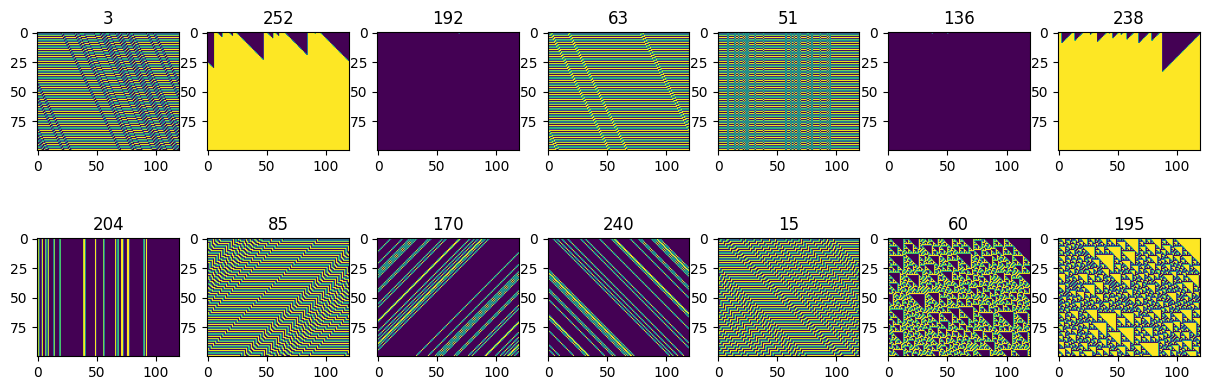

In [93]:
rules = [3,252,192,63,51,136,238,204,85,170,240,15,60,195]
print(len(rules))
plt.figure(dpi=100,figsize=(15,5))
time_len = 100
for i,rule in enumerate(rules):
    print(rule)
    plt.subplot(2,7,i+1)
    state = np.zeros(width)
    indexs = np.random.choice(99,20)
    state[indexs] = 1

    state,history = iter_CA(state, rule, time_len-1)
    plt.imshow(history)
    plt.title(rule)
plt.show()

In [126]:
# 产生元胞自动机的数据，数据存储在histories列表中，每个元素是一段历史，time_len*width, time_len时间步，width世界宽度
# 另外，产生两个邻接矩阵，adj_space是空间的网络，左右相邻，边缘是循环边界，adj_time是时间邻接的矩阵，即前后两个时刻相邻
rule=150
group_size=3
projection_rule=9
histories = []
width = 120
time_len = 180
samples = 1

for i in range(samples):
    print(i)
#     print(np.random.randint(0, 2, [width]).shape)
#     de
    state = np.zeros(width)

#     state = np.random.randint(0, 2, [width]) #生成99维的0,1随机数

    indexs = np.random.choice(99,10)
    state[indexs] = 1
    
    state,history = iter_CA(state, rule, time_len-1)
    #renormalize(history, adj_space)
    histories.append(history)
    

0
[1, 0, 0, 1, 0, 1, 1, 0]


In [127]:
histories = np.array(histories)
print(histories.shape)


(1, 180, 120)


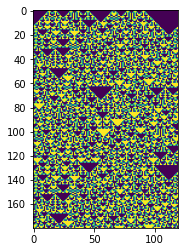

In [128]:
plt.figure()
# plt.subplot(121)
plt.imshow(histories[0,:,:])

In [115]:
import pickle as pkl

In [116]:
with open(f'../data/CA/CA_data_{rule}.pkl','wb') as f:
    pkl.dump({
        'histories':histories,
        }
             ,f)

In [74]:
histories[0,0,:]

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1])